### Sentence-Level Categorization: Question Classification

In [23]:
# Importing libraries
import tqdm
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence

In [24]:
# Set random seed for reproducibility
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

Data preprocessing

In [25]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
print("train shape before forming val set: ", train.shape)

# form a development set
val_size = 500 
val = train.sample(n=val_size, random_state=42)

# Remove these examples from the training data
train = train.drop(val.index)

# Reset the index of both train and val DataFrames
train = train.reset_index(drop=True)
val = val.reset_index(drop=True)

print("train shape after forming val set: ", train.shape)
print("val shape: ", val.shape)

train shape before forming val set:  (5452, 3)
train shape after forming val set:  (4952, 3)
val shape:  (500, 3)


**Q2a)** The 5 classes we used after converting from the original label set to the new setting are:
- 0
- 1
- 2
- 3
- 4 (OTHERS)

In [26]:
# Combine class 4 and 5 into 'OTHERS', which will be class 4

train['label-coarse'] = train['label-coarse'].replace({4: 4, 5: 4})
test['label-coarse'] = test['label-coarse'].replace({4: 4, 5: 4})
val['label-coarse'] = val['label-coarse'].replace({4: 4, 5: 4})
print(val)

     label-coarse  label-fine  \
0               4          21   
1               1           2   
2               0           9   
3               0          12   
4               3           4   
..            ...         ...   
495             1          37   
496             4          11   
497             3           5   
498             4          24   
499             0          12   

                                                  text  
0           What city is served by Tempelhol Airport ?  
1           What is Dudley Do-Right 's horse 's name ?  
2            What 's nature 's purpose for tornadoes ?  
3      What is the history of Valentine 's Day cards ?  
4    What President became Chief Justice after his ...  
..                                                 ...  
495  What 's the most commonly-spoken language in B...  
496  What is the leading pecan and peanut growing s...  
497  Name the three races unleashed by the Celestia...  
498          Where do people moun

Word embedding

In [27]:
import gensim.downloader

In [28]:
# Downloading pretrained word2vec embeddings
w2v = gensim.downloader.load('word2vec-google-news-300')

In [29]:
# Convert text data to Word2Vec embeddings
def text_to_embeddings(text, w2v_model):
    tokens = text.split()
    embeddings = [torch.tensor(w2v_model[word]) if word in w2v_model else torch.zeros(300) for word in tokens]
    return torch.stack(embeddings)

# Apply Word2Vec embeddings to data
X_train_embedded = [text_to_embeddings(text, w2v) for text in train['text']]
y_train_embedded = torch.tensor(train['label-coarse'])

X_val_embedded = [text_to_embeddings(text, w2v) for text in val['text']]
y_val_embedded = torch.tensor(val['label-coarse'])

X_test_embedded = [text_to_embeddings(text, w2v) for text in test['text']]
y_test_embedded = torch.tensor(test['label-coarse'])

# Convert the list of embedded sequences to a padded tensor
X_train_embedded= pad_sequence(X_train_embedded, batch_first=True)
X_val_embedded= pad_sequence(X_val_embedded, batch_first=True)
X_test_embedded= pad_sequence(X_test_embedded, batch_first=True)

#### Train function

In [30]:
input_dim = w2v.vector_size
output_dim = 5  

def train_model(model, num_epochs, learning_rate, train_dataset, train_loader):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Early stopping parameters
    best_val_accuracy = 0
    patience = 5
    no_improvement = 0

    epoch_loss = 0
    
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0

        # Inside training loop
        for batch in train_loader:
            optimizer.zero_grad()
            text, labels = batch

            predictions = model(text)
            loss = criterion(predictions, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        epoch_loss = total_loss / len(train_loader)

        # Evaluate on development set
        model.eval()
        with torch.no_grad():
            val_predictions = model(X_val_embedded)
            predicted_labels = torch.argmax(val_predictions, dim=1)
            predicted_labels = predicted_labels.float()

            correct = (predicted_labels == y_val_embedded).sum().item()
            val_accuracy = correct / len(y_val_embedded)

        # Check for early stopping
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            no_improvement = 0
        else:
            no_improvement += 1

        if no_improvement >= patience:
            total_training_epochs = epoch + 1
            print(f"Early stopping after {total_training_epochs} epochs")
            break

    print(f"Validation accuracy: {val_accuracy}")
    print(f"Training loss: {epoch_loss}\n")
    
    return val_accuracy, epoch_loss

In [31]:
# parameters
no_hidden = 128
num_epochs = 100

**Q2bi)** Testing out different types of aggregation methods

1. Averaging Over Word Representations

In [32]:
class AverageAggregation(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(AverageAggregation, self).__init__()
        self.lstm = nn.LSTM(input_dim, no_hidden)
        self.linear = nn.Linear(no_hidden, output_dim)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        # Average over word representations
        sentence_representation = torch.mean(lstm_out, dim=1)
        # Linear layer for classification
        output = self.linear(sentence_representation)
        # Softmax activation for classification
        output = self.softmax(output)

        return output

Hyperparameter tuning to find the optimal learning rate and batch size

In [33]:
# finding optimal hyperparameters
avg_agreg_acc = []
avg_agreg_loss = []

for learning_rate in [0.001, 0.01, 0.1]:
    for batch_size in [32, 64, 128, 256]:
        # Set hyperparameters
        learning_rate = learning_rate
        batch_size = batch_size
        
        print(f'Learning Rate: {learning_rate}, Batch Size: {batch_size}')

        # Create DataLoader for training data
        train_dataset = TensorDataset(X_train_embedded, y_train_embedded)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        
        aa_model = AverageAggregation(input_dim, output_dim)
        
        accuracy, loss = train_model(aa_model, 100, learning_rate, train_dataset, train_loader)
        avg_agreg_acc.append(accuracy)
        avg_agreg_loss.append(loss)

Learning Rate: 0.001, Batch Size: 32
Early stopping after 57 epochs
Validation accuracy: 0.828
Training loss: 1.012216031551361

Learning Rate: 0.001, Batch Size: 64
Early stopping after 46 epochs
Validation accuracy: 0.766
Training loss: 1.116794691636012

Learning Rate: 0.001, Batch Size: 128
Early stopping after 56 epochs
Validation accuracy: 0.724
Training loss: 1.2031195836189466

Learning Rate: 0.001, Batch Size: 256
Early stopping after 34 epochs
Validation accuracy: 0.586
Training loss: 1.3743156909942627

Learning Rate: 0.01, Batch Size: 32
Early stopping after 24 epochs
Validation accuracy: 0.858
Training loss: 0.9427962314698004

Learning Rate: 0.01, Batch Size: 64
Early stopping after 28 epochs
Validation accuracy: 0.852
Training loss: 0.947713166475296

Learning Rate: 0.01, Batch Size: 128
Early stopping after 35 epochs
Validation accuracy: 0.846
Training loss: 0.9670389523872962

Learning Rate: 0.01, Batch Size: 256
Early stopping after 32 epochs
Validation accuracy: 0.83

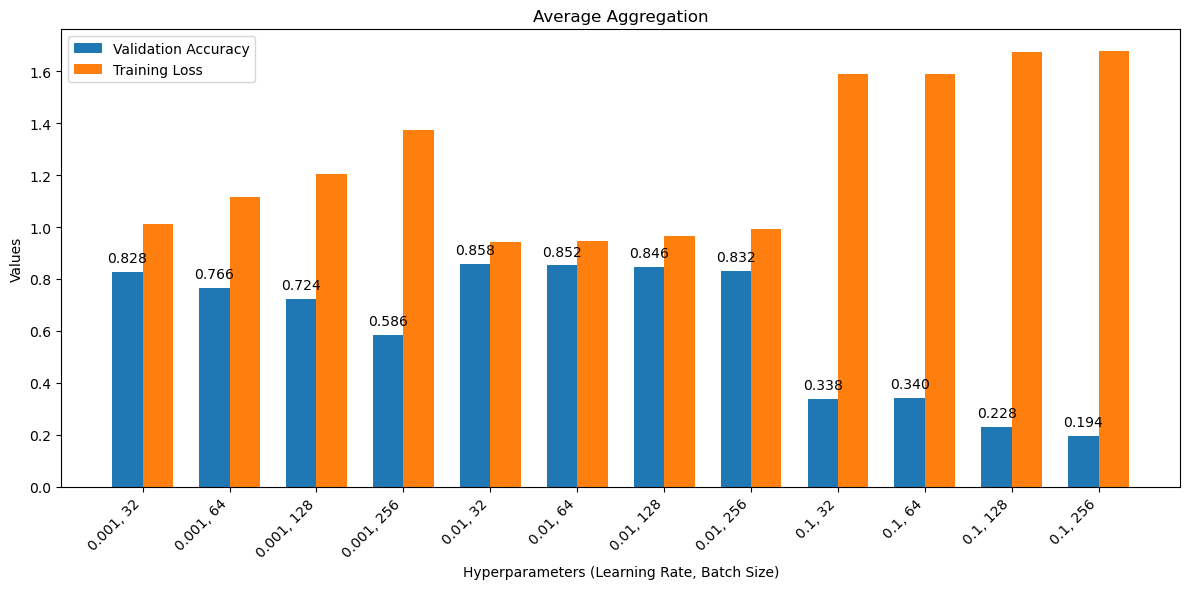

In [34]:
lr_bs = [(0.001, 32), (0.001, 64), (0.001, 128), (0.001, 256),
        (0.01, 32), (0.01, 64), (0.01, 128), (0.01, 256),
        (0.1, 32), (0.1, 64), (0.1, 128), (0.1, 256)]

batch_sizes = [bs for (_, bs) in lr_bs]
learning_rates = [lr for (lr, _) in lr_bs]


def hyperparameter_plot(accuracy, loss, title):
    # Create a bar chart with grouped bars for accuracy and loss
    fig, ax = plt.subplots(figsize=(12, 6))
    width = 0.35
    x = np.arange(len(lr_bs))

    accuracies = np.array(accuracy)
    losses = np.array(loss)

    bar1 = ax.bar(x - width/2, accuracies, width, label='Validation Accuracy')
    bar2 = ax.bar(x + width/2, losses, width, label='Training Loss')

    ax.set_xticks(x)
    ax.set_xticklabels([f"{lr}, {bs}" for lr, bs in lr_bs], rotation=45, ha="right")

    ax.set_title(title)
    ax.set_xlabel("Hyperparameters (Learning Rate, Batch Size)")
    ax.set_ylabel("Values")
    ax.legend()

    # Add labels with accuracies above the bars
    for rect, acc in zip(bar1, accuracies):
        height = rect.get_height()
        ax.annotate(f'{acc:.3f}', xy=(rect.get_x() + rect.get_width() / 2, height), xytext=(0, 5), textcoords="offset points", ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

hyperparameter_plot(avg_agreg_acc, avg_agreg_loss, "Average Aggregation")

In [35]:
# train with optimal hyperparameters (highest accuracy, lowest loss)
learning_rate = 0.01
batch_size = 32

aa_model = AverageAggregation(input_dim, output_dim)

train_dataset = TensorDataset(X_train_embedded, y_train_embedded)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        
train_model(aa_model, 100, learning_rate, train_dataset, train_loader)

Early stopping after 18 epochs
Validation accuracy: 0.846
Training loss: 0.9554366969293163



(0.846, 0.9554366969293163)

2. Max Pooling

In [36]:
class MaxPoolAggre(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(MaxPoolAggre, self).__init__()
        self.lstm = nn.LSTM(input_dim, no_hidden)
        self.linear = nn.Linear(no_hidden, output_dim)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        # Max pooling over word representations
        sentence_representation, _ = torch.max(lstm_out, dim=1)
        # Linear layer for classification
        output = self.linear(sentence_representation)
        # Softmax activation for classification
        output = self.softmax(output)

        return output

In [37]:
# finding optimal hyperparameters
max_agreg_acc = []
max_agreg_loss = []

for learning_rate in [0.001, 0.01, 0.1]:
    for batch_size in [32, 64, 128, 256]:
        # Set hyperparameters
        learning_rate = learning_rate
        batch_size = batch_size
        
        print(f'Learning Rate: {learning_rate}, Batch Size: {batch_size}')

        # Create DataLoader for training data
        train_dataset = TensorDataset(X_train_embedded, y_train_embedded)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        
        mpa_model = MaxPoolAggre(input_dim, output_dim)
        
        accuracy, loss = train_model(mpa_model, 100, learning_rate, train_dataset, train_loader)
        max_agreg_acc.append(accuracy)
        max_agreg_loss.append(loss)

Learning Rate: 0.001, Batch Size: 32
Early stopping after 16 epochs
Validation accuracy: 0.858
Training loss: 0.9761257994559503

Learning Rate: 0.001, Batch Size: 64
Early stopping after 21 epochs
Validation accuracy: 0.872
Training loss: 0.9770024946102729

Learning Rate: 0.001, Batch Size: 128
Early stopping after 40 epochs
Validation accuracy: 0.872
Training loss: 0.9631882798977387

Learning Rate: 0.001, Batch Size: 256
Early stopping after 45 epochs
Validation accuracy: 0.866
Training loss: 0.9817473381757736

Learning Rate: 0.01, Batch Size: 32
Early stopping after 17 epochs
Validation accuracy: 0.856
Training loss: 0.9421421627844534

Learning Rate: 0.01, Batch Size: 64
Early stopping after 26 epochs
Validation accuracy: 0.866
Training loss: 0.9377289911111196

Learning Rate: 0.01, Batch Size: 128
Early stopping after 17 epochs
Validation accuracy: 0.88
Training loss: 0.9438040669147785

Learning Rate: 0.01, Batch Size: 256
Early stopping after 18 epochs
Validation accuracy: 0.

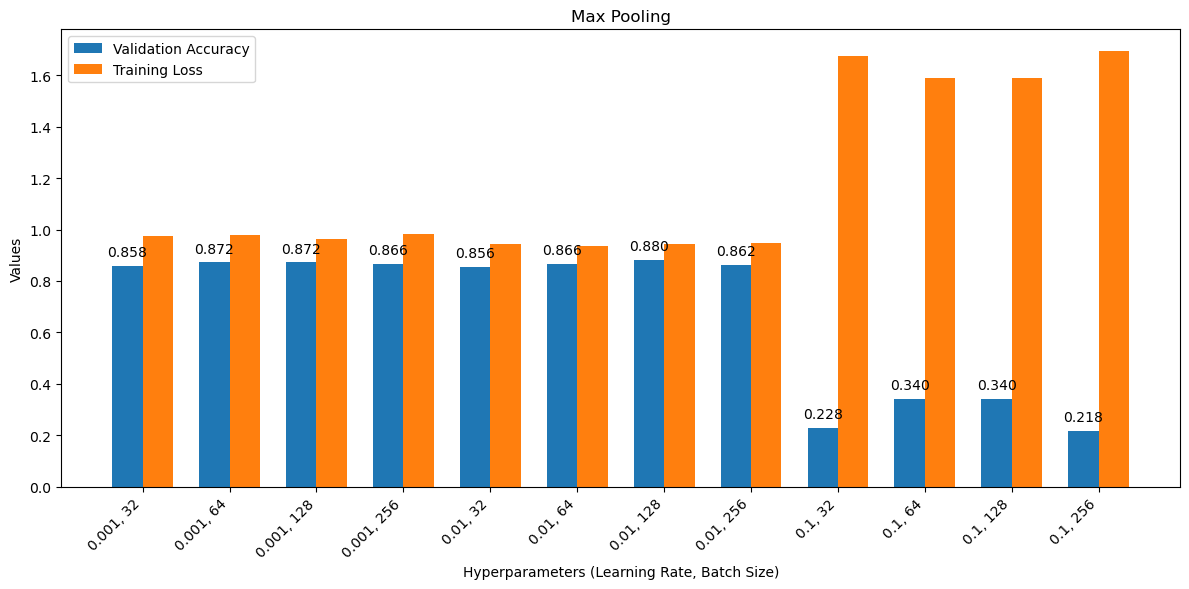

In [38]:
hyperparameter_plot(max_agreg_acc, max_agreg_loss, "Max Pooling")

In [39]:
# train with optimal hyperparameters (highest accuracy, lowest loss)
learning_rate = 0.01
batch_size = 128

mpa_model = MaxPoolAggre(input_dim, output_dim)

train_dataset = TensorDataset(X_train_embedded, y_train_embedded)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        
train_model(mpa_model, 100, learning_rate, train_dataset, train_loader)

Early stopping after 20 epochs
Validation accuracy: 0.878
Training loss: 0.941215299643003



(0.878, 0.941215299643003)

3. Taking Representation of the Last Word

In [40]:
class LastWordAggre(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LastWordAggre, self).__init__()
        self.lstm = nn.LSTM(input_dim, no_hidden)
        self.linear = nn.Linear(no_hidden, output_dim)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        # Use the representation of the last word
        sentence_representation = lstm_out[:, -1, :]
        # Linear layer for classification
        output = self.linear(sentence_representation)
        # Softmax activation for classification
        output = self.softmax(output)

        return output

In [41]:
# finding optimal hyperparameters
last_word_agreg_acc = []
last_word_agreg_loss = []

for learning_rate in [0.001, 0.01, 0.1]:
    for batch_size in [32, 64, 128, 256]:
        # Set hyperparameters
        learning_rate = learning_rate
        batch_size = batch_size
        
        print(f'Learning Rate: {learning_rate}, Batch Size: {batch_size}')

        # Create DataLoader for training data
        train_dataset = TensorDataset(X_train_embedded, y_train_embedded)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        
        lwa_model = LastWordAggre(input_dim, output_dim)
        
        accuracy, loss = train_model(lwa_model, 100, learning_rate, train_dataset, train_loader)
        last_word_agreg_acc.append(accuracy)
        last_word_agreg_loss.append(loss)

Learning Rate: 0.001, Batch Size: 32
Early stopping after 7 epochs
Validation accuracy: 0.34
Training loss: 1.5544950377556586

Learning Rate: 0.001, Batch Size: 64
Early stopping after 6 epochs
Validation accuracy: 0.34
Training loss: 1.5538865816898835

Learning Rate: 0.001, Batch Size: 128
Early stopping after 6 epochs
Validation accuracy: 0.338
Training loss: 1.555612209515694

Learning Rate: 0.001, Batch Size: 256
Early stopping after 6 epochs
Validation accuracy: 0.338
Training loss: 1.556158471107483

Learning Rate: 0.01, Batch Size: 32
Early stopping after 6 epochs
Validation accuracy: 0.34
Training loss: 1.5551270838706723

Learning Rate: 0.01, Batch Size: 64
Early stopping after 7 epochs
Validation accuracy: 0.34
Training loss: 1.5547980681443825

Learning Rate: 0.01, Batch Size: 128
Early stopping after 8 epochs
Validation accuracy: 0.34
Training loss: 1.5547149456464326

Learning Rate: 0.01, Batch Size: 256
Early stopping after 6 epochs
Validation accuracy: 0.34
Training lo

In [43]:
# train with optimal hyperparameters (highest accuracy, lowest loss)
learning_rate = 0.001
batch_size = 64

lwa_model = LastWordAggre(input_dim, output_dim)

train_dataset = TensorDataset(X_train_embedded, y_train_embedded)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        
train_model(lwa_model, 100, learning_rate, train_dataset, train_loader)

Early stopping after 6 epochs
Validation accuracy: 0.338
Training loss: 1.5553957942204597



(0.338, 1.5553957942204597)

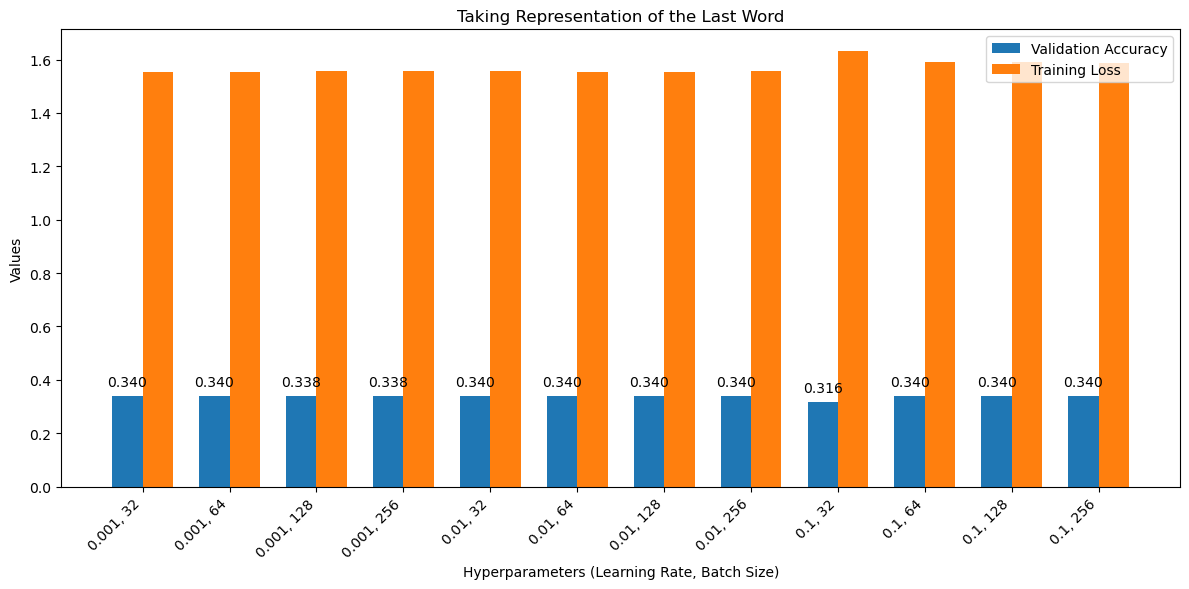

In [21]:
hyperparameter_plot(last_word_agreg_acc, last_word_agreg_loss, "Taking Representation of the Last Word")

**Q2bii)** 

**Aggregation methods and their accuracy:**
1. Averaging Over Word Representations, Accuracy: 0.846
2. Max Pooling, Accuracy: 0.870
3. Taking Representation of the Last Word, Accuracy: 0.340


**Final Aggregation method adopted:**

The aggregation method that is finally adopted is *max pooling* as it leads to the highest validation accuracy of 0.870. 


**Function of the max pooling aggregation method:**

*sentence_representation, _ = torch.max(lstm_out, dim=1)*

The LSTM layer generates an output vector for each word in the input sequence. To capture the most significant features representing the entire sentence, the torch.max function extracts the maximum value from these vectors along the time dimension (specified as dim=1).

In [9]:
class QnsClassifier(nn.Module):
    def __init__(self, input_dim, output_dim, no_hidden):
        super(QnsClassifier, self).__init__()
        self.lstm = nn.LSTM(input_dim, no_hidden)
        self.linear = nn.Linear(no_hidden, output_dim)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        # Max pooling over word representations
        sentence_representation, _ = torch.max(lstm_out, dim=1)
        # print("Shape of final vector representation of each word fed to softmax classifier: ",sentence_representation.shape)
        # Linear layer for classification
        output = self.linear(sentence_representation)
        # Softmax activation for classification
        output = self.softmax(output)

        return output

In [10]:
!pip install optuna

In [12]:
import optuna

def objective(trial):
    
    no_hidden = trial.suggest_int('no_hidden', 32, 256)
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-1, log=True)
    batch_size = trial.suggest_int('batch_size', 32, 256)

    model = QnsClassifier(input_dim, output_dim, no_hidden)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    train_dataset = TensorDataset(X_train_embedded, y_train_embedded)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    
    accuracy, loss = train_model(model, 100, learning_rate, train_dataset, train_loader)

    return loss

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)
study.best_params

[I 2023-11-03 14:55:33,847] A new study created in memory with name: no-name-e3409d03-da04-4731-88f3-674bb93b6785
[I 2023-11-03 15:00:42,280] Trial 0 finished with value: 1.1901525486083258 and parameters: {'no_hidden': 159, 'learning_rate': 0.00010560270411531317, 'batch_size': 246}. Best is trial 0 with value: 1.1901525486083258.


Early stopping after 68 epochs
Validation accuracy: 0.762
Training loss: 1.1901525486083258



[I 2023-11-03 15:01:07,061] Trial 1 finished with value: 0.9530293229553435 and parameters: {'no_hidden': 44, 'learning_rate': 0.05005603446110368, 'batch_size': 140}. Best is trial 1 with value: 0.9530293229553435.


Early stopping after 17 epochs
Validation accuracy: 0.856
Training loss: 0.9530293229553435



[I 2023-11-03 15:03:46,265] Trial 2 finished with value: 1.1588554514778986 and parameters: {'no_hidden': 94, 'learning_rate': 0.00014285568099603067, 'batch_size': 186}. Best is trial 1 with value: 0.9530293229553435.


Early stopping after 60 epochs
Validation accuracy: 0.776
Training loss: 1.1588554514778986



[I 2023-11-03 15:08:12,716] Trial 3 finished with value: 1.0406562398586954 and parameters: {'no_hidden': 182, 'learning_rate': 0.0001778508373179377, 'batch_size': 89}. Best is trial 1 with value: 0.9530293229553435.


Early stopping after 52 epochs
Validation accuracy: 0.832
Training loss: 1.0406562398586954



[I 2023-11-03 15:13:04,412] Trial 4 finished with value: 1.1006257840105005 and parameters: {'no_hidden': 253, 'learning_rate': 0.00011139569309223305, 'batch_size': 67}. Best is trial 1 with value: 0.9530293229553435.


Early stopping after 35 epochs
Validation accuracy: 0.796
Training loss: 1.1006257840105005



[I 2023-11-03 15:13:45,668] Trial 5 finished with value: 1.5448125749826431 and parameters: {'no_hidden': 172, 'learning_rate': 5.828084502906078e-05, 'batch_size': 209}. Best is trial 1 with value: 0.9530293229553435.


Early stopping after 8 epochs
Validation accuracy: 0.34
Training loss: 1.5448125749826431



[I 2023-11-03 15:15:21,362] Trial 6 finished with value: 0.9803636997938157 and parameters: {'no_hidden': 199, 'learning_rate': 0.003163590313476959, 'batch_size': 249}. Best is trial 1 with value: 0.9530293229553435.


Early stopping after 17 epochs
Validation accuracy: 0.856
Training loss: 0.9803636997938157



[I 2023-11-03 15:17:00,952] Trial 7 finished with value: 0.9437588777458459 and parameters: {'no_hidden': 220, 'learning_rate': 0.014265134889761728, 'batch_size': 87}. Best is trial 7 with value: 0.9437588777458459.


Early stopping after 15 epochs
Validation accuracy: 0.866
Training loss: 0.9437588777458459



[I 2023-11-03 15:19:21,765] Trial 8 finished with value: 1.1105232624446644 and parameters: {'no_hidden': 107, 'learning_rate': 0.00024092820850544168, 'batch_size': 148}. Best is trial 7 with value: 0.9437588777458459.


Early stopping after 44 epochs
Validation accuracy: 0.81
Training loss: 1.1105232624446644



[I 2023-11-03 15:19:46,096] Trial 9 finished with value: 1.5744757088454995 and parameters: {'no_hidden': 70, 'learning_rate': 1.5540567442759363e-05, 'batch_size': 67}. Best is trial 7 with value: 0.9437588777458459.


Early stopping after 10 epochs
Validation accuracy: 0.34
Training loss: 1.5744757088454995



[I 2023-11-03 15:22:52,618] Trial 10 finished with value: 0.9248236521597831 and parameters: {'no_hidden': 252, 'learning_rate': 0.007211412105088788, 'batch_size': 32}. Best is trial 10 with value: 0.9248236521597831.


Early stopping after 20 epochs
Validation accuracy: 0.862
Training loss: 0.9248236521597831



[I 2023-11-03 15:24:45,171] Trial 11 finished with value: 0.941198483661369 and parameters: {'no_hidden': 248, 'learning_rate': 0.008085634203482694, 'batch_size': 46}. Best is trial 10 with value: 0.9248236521597831.


Early stopping after 13 epochs
Validation accuracy: 0.888
Training loss: 0.941198483661369



[I 2023-11-03 15:26:48,768] Trial 12 finished with value: 0.9528280555746937 and parameters: {'no_hidden': 256, 'learning_rate': 0.002899857893183685, 'batch_size': 38}. Best is trial 10 with value: 0.9248236521597831.


Early stopping after 13 epochs
Validation accuracy: 0.868
Training loss: 0.9528280555746937



[I 2023-11-03 15:29:44,765] Trial 13 finished with value: 0.9242933746307127 and parameters: {'no_hidden': 221, 'learning_rate': 0.011812627647641677, 'batch_size': 32}. Best is trial 13 with value: 0.9242933746307127.


Early stopping after 21 epochs
Validation accuracy: 0.866
Training loss: 0.9242933746307127



[I 2023-11-03 15:35:13,925] Trial 14 finished with value: 1.6755064493272362 and parameters: {'no_hidden': 217, 'learning_rate': 0.07710014467247019, 'batch_size': 121}. Best is trial 13 with value: 0.9242933746307127.


Early stopping after 6 epochs
Validation accuracy: 0.228
Training loss: 1.6755064493272362



[I 2023-11-03 15:36:51,390] Trial 15 finished with value: 0.9985355419271132 and parameters: {'no_hidden': 133, 'learning_rate': 0.0010400649106497078, 'batch_size': 99}. Best is trial 13 with value: 0.9242933746307127.


Early stopping after 26 epochs
Validation accuracy: 0.856
Training loss: 0.9985355419271132



[I 2023-11-03 15:38:58,076] Trial 16 finished with value: 0.9657807084821886 and parameters: {'no_hidden': 221, 'learning_rate': 0.018563034746502893, 'batch_size': 32}. Best is trial 13 with value: 0.9242933746307127.


Early stopping after 17 epochs
Validation accuracy: 0.832
Training loss: 0.9657807084821886



[I 2023-11-03 15:39:52,168] Trial 17 finished with value: 0.9620837455704099 and parameters: {'no_hidden': 137, 'learning_rate': 0.040199769272320766, 'batch_size': 59}. Best is trial 13 with value: 0.9242933746307127.


Early stopping after 13 epochs
Validation accuracy: 0.854
Training loss: 0.9620837455704099



[I 2023-11-03 15:41:41,884] Trial 18 finished with value: 0.9416187784888528 and parameters: {'no_hidden': 196, 'learning_rate': 0.005435379102870937, 'batch_size': 114}. Best is trial 13 with value: 0.9242933746307127.


Early stopping after 20 epochs
Validation accuracy: 0.88
Training loss: 0.9416187784888528



[I 2023-11-03 15:45:17,251] Trial 19 finished with value: 0.9733335927680686 and parameters: {'no_hidden': 232, 'learning_rate': 0.0012442170120967697, 'batch_size': 190}. Best is trial 13 with value: 0.9242933746307127.


Early stopping after 33 epochs
Validation accuracy: 0.868
Training loss: 0.9733335927680686



[I 2023-11-03 15:47:16,851] Trial 20 finished with value: 1.2038200310298375 and parameters: {'no_hidden': 200, 'learning_rate': 0.030388083419358877, 'batch_size': 71}. Best is trial 13 with value: 0.9242933746307127.


Early stopping after 20 epochs
Validation accuracy: 0.672
Training loss: 1.2038200310298375



[I 2023-11-03 15:49:21,595] Trial 21 finished with value: 0.9406699110976363 and parameters: {'no_hidden': 239, 'learning_rate': 0.009232675838504055, 'batch_size': 44}. Best is trial 13 with value: 0.9242933746307127.


Early stopping after 16 epochs
Validation accuracy: 0.86
Training loss: 0.9406699110976363



[I 2023-11-03 15:50:45,053] Trial 22 finished with value: 0.9462475742063214 and parameters: {'no_hidden': 236, 'learning_rate': 0.012438448260159335, 'batch_size': 32}. Best is trial 13 with value: 0.9242933746307127.


Early stopping after 11 epochs
Validation accuracy: 0.862
Training loss: 0.9462475742063214



[I 2023-11-03 15:52:14,805] Trial 23 finished with value: 0.9505786178063373 and parameters: {'no_hidden': 235, 'learning_rate': 0.006437326588409217, 'batch_size': 51}. Best is trial 13 with value: 0.9242933746307127.


Early stopping after 12 epochs
Validation accuracy: 0.864
Training loss: 0.9505786178063373



[I 2023-11-03 15:57:25,770] Trial 24 finished with value: 1.588758546859026 and parameters: {'no_hidden': 214, 'learning_rate': 0.09973455543365448, 'batch_size': 78}. Best is trial 13 with value: 0.9242933746307127.


Early stopping after 6 epochs
Validation accuracy: 0.34
Training loss: 1.588758546859026



[I 2023-11-03 15:58:47,430] Trial 25 finished with value: 0.948325936283384 and parameters: {'no_hidden': 178, 'learning_rate': 0.022107477784543576, 'batch_size': 51}. Best is trial 13 with value: 0.9242933746307127.


Early stopping after 16 epochs
Validation accuracy: 0.848
Training loss: 0.948325936283384



[I 2023-11-03 16:01:17,362] Trial 26 finished with value: 0.9445108974233587 and parameters: {'no_hidden': 242, 'learning_rate': 0.0025735937207681516, 'batch_size': 106}. Best is trial 13 with value: 0.9242933746307127.


Early stopping after 22 epochs
Validation accuracy: 0.866
Training loss: 0.9445108974233587



[I 2023-11-03 16:02:10,844] Trial 27 finished with value: 0.9532647497124143 and parameters: {'no_hidden': 203, 'learning_rate': 0.010571958831686776, 'batch_size': 138}. Best is trial 13 with value: 0.9242933746307127.


Early stopping after 10 epochs
Validation accuracy: 0.864
Training loss: 0.9532647497124143



[I 2023-11-03 16:03:21,889] Trial 28 finished with value: 0.941018453959761 and parameters: {'no_hidden': 159, 'learning_rate': 0.02608111928312375, 'batch_size': 57}. Best is trial 13 with value: 0.9242933746307127.


Early stopping after 16 epochs
Validation accuracy: 0.882
Training loss: 0.941018453959761



[I 2023-11-03 16:04:52,920] Trial 29 finished with value: 0.9450944142956887 and parameters: {'no_hidden': 154, 'learning_rate': 0.004538356458269733, 'batch_size': 162}. Best is trial 13 with value: 0.9242933746307127.


Early stopping after 23 epochs
Validation accuracy: 0.878
Training loss: 0.9450944142956887



[I 2023-11-03 16:06:20,574] Trial 30 finished with value: 0.9539690069530321 and parameters: {'no_hidden': 233, 'learning_rate': 0.009764440143064506, 'batch_size': 223}. Best is trial 13 with value: 0.9242933746307127.


Early stopping after 14 epochs
Validation accuracy: 0.866
Training loss: 0.9539690069530321



[I 2023-11-03 16:07:57,941] Trial 31 finished with value: 1.185629035912308 and parameters: {'no_hidden': 160, 'learning_rate': 0.02807900578632475, 'batch_size': 49}. Best is trial 13 with value: 0.9242933746307127.


Early stopping after 14 epochs
Validation accuracy: 0.706
Training loss: 1.185629035912308



[I 2023-11-03 16:08:42,266] Trial 32 finished with value: 0.9680930608656348 and parameters: {'no_hidden': 108, 'learning_rate': 0.049576105582185746, 'batch_size': 61}. Best is trial 13 with value: 0.9242933746307127.


Early stopping after 15 epochs
Validation accuracy: 0.862
Training loss: 0.9680930608656348



[I 2023-11-03 16:09:02,539] Trial 33 finished with value: 0.96493810607541 and parameters: {'no_hidden': 33, 'learning_rate': 0.019498250996088647, 'batch_size': 32}. Best is trial 13 with value: 0.9242933746307127.


Early stopping after 13 epochs
Validation accuracy: 0.848
Training loss: 0.96493810607541



[I 2023-11-03 16:09:43,241] Trial 34 finished with value: 0.9493197466506332 and parameters: {'no_hidden': 125, 'learning_rate': 0.03599132601886936, 'batch_size': 82}. Best is trial 13 with value: 0.9242933746307127.


Early stopping after 12 epochs
Validation accuracy: 0.874
Training loss: 0.9493197466506332



[I 2023-11-03 16:10:36,437] Trial 35 finished with value: 0.9651583943281088 and parameters: {'no_hidden': 189, 'learning_rate': 0.012657003077821501, 'batch_size': 45}. Best is trial 13 with value: 0.9242933746307127.


Early stopping after 10 epochs
Validation accuracy: 0.874
Training loss: 0.9651583943281088



[I 2023-11-03 16:11:04,130] Trial 36 finished with value: 0.9611214454527255 and parameters: {'no_hidden': 77, 'learning_rate': 0.056183788159560925, 'batch_size': 92}. Best is trial 13 with value: 0.9242933746307127.


Early stopping after 12 epochs
Validation accuracy: 0.844
Training loss: 0.9611214454527255



[I 2023-11-03 16:12:11,626] Trial 37 finished with value: 0.9426059902432453 and parameters: {'no_hidden': 164, 'learning_rate': 0.005859868569435666, 'batch_size': 60}. Best is trial 13 with value: 0.9242933746307127.


Early stopping after 15 epochs
Validation accuracy: 0.87
Training loss: 0.9426059902432453



[I 2023-11-03 16:13:52,594] Trial 38 finished with value: 1.0244569627206717 and parameters: {'no_hidden': 208, 'learning_rate': 0.022097214018357837, 'batch_size': 75}. Best is trial 13 with value: 0.9242933746307127.


Early stopping after 14 epochs
Validation accuracy: 0.806
Training loss: 1.0244569627206717



[I 2023-11-03 16:17:19,686] Trial 39 finished with value: 0.9402580805893602 and parameters: {'no_hidden': 253, 'learning_rate': 0.0018885852571691385, 'batch_size': 43}. Best is trial 13 with value: 0.9242933746307127.


Early stopping after 26 epochs
Validation accuracy: 0.884
Training loss: 0.9402580805893602



[I 2023-11-03 16:20:30,025] Trial 40 finished with value: 0.9449331765776282 and parameters: {'no_hidden': 256, 'learning_rate': 0.002178613657538202, 'batch_size': 45}. Best is trial 13 with value: 0.9242933746307127.


Early stopping after 24 epochs
Validation accuracy: 0.866
Training loss: 0.9449331765776282



[I 2023-11-03 16:22:46,900] Trial 41 finished with value: 0.9340339522252138 and parameters: {'no_hidden': 224, 'learning_rate': 0.007977885799341592, 'batch_size': 57}. Best is trial 13 with value: 0.9242933746307127.


Early stopping after 21 epochs
Validation accuracy: 0.874
Training loss: 0.9340339522252138



[I 2023-11-03 16:24:59,775] Trial 42 finished with value: 0.9372032442979054 and parameters: {'no_hidden': 224, 'learning_rate': 0.00434735863649756, 'batch_size': 44}. Best is trial 13 with value: 0.9242933746307127.


Early stopping after 20 epochs
Validation accuracy: 0.876
Training loss: 0.9372032442979054



[I 2023-11-03 16:26:45,412] Trial 43 finished with value: 0.9445740327443162 and parameters: {'no_hidden': 229, 'learning_rate': 0.0038889817827623377, 'batch_size': 68}. Best is trial 13 with value: 0.9242933746307127.


Early stopping after 16 epochs
Validation accuracy: 0.878
Training loss: 0.9445740327443162



[I 2023-11-03 16:29:04,348] Trial 44 finished with value: 0.9511994692205473 and parameters: {'no_hidden': 247, 'learning_rate': 0.0016910242751221047, 'batch_size': 38}. Best is trial 13 with value: 0.9242933746307127.


Early stopping after 18 epochs
Validation accuracy: 0.864
Training loss: 0.9511994692205473



[I 2023-11-03 16:30:40,235] Trial 45 finished with value: 0.94461952836326 and parameters: {'no_hidden': 220, 'learning_rate': 0.004058173730647226, 'batch_size': 56}. Best is trial 13 with value: 0.9242933746307127.


Early stopping after 15 epochs
Validation accuracy: 0.874
Training loss: 0.94461952836326



[I 2023-11-03 16:33:06,214] Trial 46 finished with value: 0.9396017465675086 and parameters: {'no_hidden': 225, 'learning_rate': 0.006999602493992674, 'batch_size': 88}. Best is trial 13 with value: 0.9242933746307127.


Early stopping after 23 epochs
Validation accuracy: 0.874
Training loss: 0.9396017465675086



[I 2023-11-03 16:34:21,773] Trial 47 finished with value: 0.9488945352403741 and parameters: {'no_hidden': 189, 'learning_rate': 0.007327986247965991, 'batch_size': 88}. Best is trial 13 with value: 0.9242933746307127.


Early stopping after 15 epochs
Validation accuracy: 0.862
Training loss: 0.9488945352403741



[I 2023-11-03 16:36:05,570] Trial 48 finished with value: 0.9476096034049988 and parameters: {'no_hidden': 225, 'learning_rate': 0.0034506346867813156, 'batch_size': 67}. Best is trial 13 with value: 0.9242933746307127.


Early stopping after 16 epochs
Validation accuracy: 0.872
Training loss: 0.9476096034049988



[I 2023-11-03 16:40:25,151] Trial 49 finished with value: 0.9762470963838938 and parameters: {'no_hidden': 245, 'learning_rate': 0.000692804333848117, 'batch_size': 134}. Best is trial 13 with value: 0.9242933746307127.


Early stopping after 38 epochs
Validation accuracy: 0.862
Training loss: 0.9762470963838938



{'no_hidden': 221, 'learning_rate': 0.011812627647641677, 'batch_size': 32}

**Q2c)** Parameters that are updated and their sizes

In [13]:
# hyperparameters
input_dim = w2v.vector_size
output_dim = 5  
no_hidden = 221
learning_rate = 0.011812627647641677
batch_size = 32
num_epochs = 100

In [27]:
model = QnsClassifier(input_dim, output_dim, no_hidden)

for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.shape)

lstm.weight_ih_l0 torch.Size([884, 300])
lstm.weight_hh_l0 torch.Size([884, 221])
lstm.bias_ih_l0 torch.Size([884])
lstm.bias_hh_l0 torch.Size([884])
linear.weight torch.Size([5, 221])
linear.bias torch.Size([5])


**Q2d & Q2e)** 

In [28]:
def train_on_test(model):
    train_dataset = TensorDataset(X_train_embedded, y_train_embedded)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Early stopping parameters
    best_val_accuracy = 0
    patience = 5
    no_improvement = 0

    training_losses = []
    training_accuracies = []
    val_losses = []
    val_accuracies = []
    test_losses = []
    test_accuracies = []

    start_time = time.time()
    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0       
        train_correct = 0
        total_samples = 0

        # Inside your training loop
        for batch in train_loader:
            optimizer.zero_grad()
            text, labels = batch

            train_predictions = model(text)
            train_loss = criterion(train_predictions, labels)
            train_loss.backward()
            optimizer.step()
            total_train_loss += train_loss.item()
            
            train_predicted_labels = torch.argmax(train_predictions, dim=1)
            train_correct += (train_predicted_labels == labels).sum().item()
            total_samples += len(labels)

        training_loss = total_train_loss / len(train_loader)
        training_losses.append(training_loss)
        training_accuracy = train_correct / total_samples
        training_accuracies.append(training_accuracy)

        print(f'\nEpoch {epoch + 1}/{num_epochs}')
        print(f'Training Accuracy: {training_accuracy} | Training Loss: {training_loss}')

        # Evaluate on development set
        model.eval()
        with torch.no_grad():
            val_predictions = model(X_val_embedded)
            
            val_loss = criterion(val_predictions, y_val_embedded)
            val_losses.append(val_loss.item())
            
            val_predicted_labels = torch.argmax(val_predictions, dim=1)
            val_predicted_labels = val_predicted_labels.float()

            val_correct = (val_predicted_labels == y_val_embedded).sum().item()
            val_accuracy = val_correct / len(y_val_embedded)
            val_accuracies.append(val_accuracy)

        print(f'Val Accuracy: {val_accuracy} | Val Loss: {val_loss}')

        # Evaluate on test data
        with torch.no_grad():
            test_predictions = model(X_test_embedded)
            
            test_loss = criterion(test_predictions, y_test_embedded)
            test_losses.append(test_loss.item())
            
            test_predicted_labels = torch.argmax(test_predictions, dim=1)
            test_predicted_labels = test_predicted_labels.float()

            test_correct = (test_predicted_labels == y_test_embedded).sum().item()
            test_accuracy = test_correct / len(y_test_embedded)
            test_accuracies.append(test_accuracy)

        print(f'Test Accuracy: {test_accuracy} | Test Loss: {test_loss}')

        # Check for early stopping
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            no_improvement = 0
        else:
            no_improvement += 1

        if no_improvement >= patience:
            end_time = time.time()
            training_time = end_time - start_time
            print(f"Early stopping after {epoch + 1} epochs. No improvement on the development set.")
            print(f"Number of epochs used for training: {epoch + 1}")
            print(f"Training time: {training_time:.2f} seconds")
            break
            
    return training_accuracies, val_accuracies, test_accuracies, training_losses, val_losses, test_losses

training_accuracies, val_accuracies, test_accuracies, training_losses, val_losses, test_losses = train_on_test(model)


Epoch 1/100
Training Accuracy: 0.6736672051696284 | Training Loss: 1.2409739671214934
Val Accuracy: 0.812 | Val Loss: 1.1065130233764648
Test Accuracy: 0.814 | Test Loss: 1.0974669456481934

Epoch 2/100
Training Accuracy: 0.8556138933764136 | Training Loss: 1.060854919110575
Val Accuracy: 0.838 | Val Loss: 1.0715059041976929
Test Accuracy: 0.884 | Test Loss: 1.0322977304458618

Epoch 3/100
Training Accuracy: 0.8939822294022617 | Training Loss: 1.0206965358026565
Val Accuracy: 0.85 | Val Loss: 1.0630159378051758
Test Accuracy: 0.848 | Test Loss: 1.0544860363006592

Epoch 4/100
Training Accuracy: 0.9186187399030694 | Training Loss: 0.9964387739858319
Val Accuracy: 0.854 | Val Loss: 1.0505754947662354
Test Accuracy: 0.88 | Test Loss: 1.0260858535766602

Epoch 5/100
Training Accuracy: 0.9301292407108239 | Training Loss: 0.9821789107015056
Val Accuracy: 0.856 | Val Loss: 1.0496762990951538
Test Accuracy: 0.892 | Test Loss: 1.0228513479232788

Epoch 6/100
Training Accuracy: 0.93840872374798

In [30]:
training_accuracies, val_accuracies, test_accuracies, training_losses, val_losses, test_losses

([0.6736672051696284,
  0.8556138933764136,
  0.8939822294022617,
  0.9186187399030694,
  0.9301292407108239,
  0.9384087237479806,
  0.9478998384491115,
  0.9501211631663974,
  0.9573909531502424,
  0.9610258481421647,
  0.965670436187399,
  0.9691033925686591,
  0.9739499192245558,
  0.9759693053311793,
  0.9787964458804523,
  0.97859450726979,
  0.97859450726979,
  0.9773828756058158],
 [0.812,
  0.838,
  0.85,
  0.854,
  0.856,
  0.868,
  0.852,
  0.868,
  0.874,
  0.856,
  0.864,
  0.878,
  0.884,
  0.884,
  0.874,
  0.884,
  0.868,
  0.864],
 [0.814,
  0.884,
  0.848,
  0.88,
  0.892,
  0.892,
  0.886,
  0.892,
  0.894,
  0.886,
  0.89,
  0.904,
  0.916,
  0.91,
  0.906,
  0.914,
  0.898,
  0.89],
 [1.2409739671214934,
  1.060854919110575,
  1.0206965358026565,
  0.9964387739858319,
  0.9821789107015056,
  0.9732751996286454,
  0.9640784844275444,
  0.9594281631131326,
  0.9511780238920643,
  0.9478793874863656,
  0.9432236832957114,
  0.9395661415592317,
  0.9339110466741747,
  

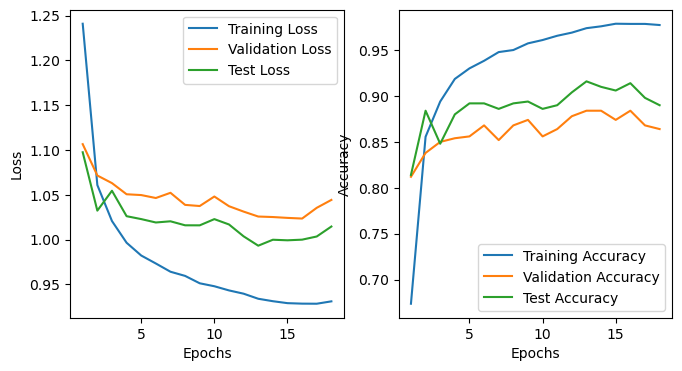

In [32]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.plot(list(range(1, len(training_losses) + 1)), training_losses, label='Training Loss')
plt.plot(list(range(1, len(val_losses) + 1)), val_losses, label='Validation Loss')
plt.plot(list(range(1, len(test_losses) + 1)), test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(list(range(1, len(training_accuracies) + 1)), training_accuracies, label='Training Accuracy')
plt.plot(list(range(1, len(val_accuracies) + 1)), val_accuracies, label='Validation Accuracy')
plt.plot(list(range(1, len(test_accuracies) + 1)), test_accuracies, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### Appendix

Model not chosen: Linear

In [34]:
class LinearClassifier(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LinearClassifier, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        linear_out = self.linear(x)
        sentence_representation, _ = torch.max(linear_out, dim=1)
        output = self.softmax(sentence_representation)
        return output

model = LinearClassifier(input_dim, output_dim)
    
training_accuracies, val_accuracies, test_accuracies, training_losses, val_losses, test_losses = train_on_test(model)


Epoch 1/100
Training Accuracy: 0.5197899838449112 | Training Loss: 1.3866646451334799
Val Accuracy: 0.572 | Val Loss: 1.3269073963165283
Test Accuracy: 0.496 | Test Loss: 1.367289662361145

Epoch 2/100
Training Accuracy: 0.6015751211631664 | Training Loss: 1.3025348624875468
Val Accuracy: 0.596 | Val Loss: 1.300195336341858
Test Accuracy: 0.514 | Test Loss: 1.3495618104934692

Epoch 3/100
Training Accuracy: 0.6775040387722132 | Training Loss: 1.2391547579919138
Val Accuracy: 0.674 | Val Loss: 1.2357313632965088
Test Accuracy: 0.65 | Test Loss: 1.2461720705032349

Epoch 4/100
Training Accuracy: 0.7114297253634895 | Training Loss: 1.2038506761673957
Val Accuracy: 0.684 | Val Loss: 1.2235456705093384
Test Accuracy: 0.636 | Test Loss: 1.2558742761611938

Epoch 5/100
Training Accuracy: 0.7271809369951535 | Training Loss: 1.188607665031187
Val Accuracy: 0.692 | Val Loss: 1.2163441181182861
Test Accuracy: 0.68 | Test Loss: 1.2233846187591553

Epoch 6/100
Training Accuracy: 0.744951534733441 

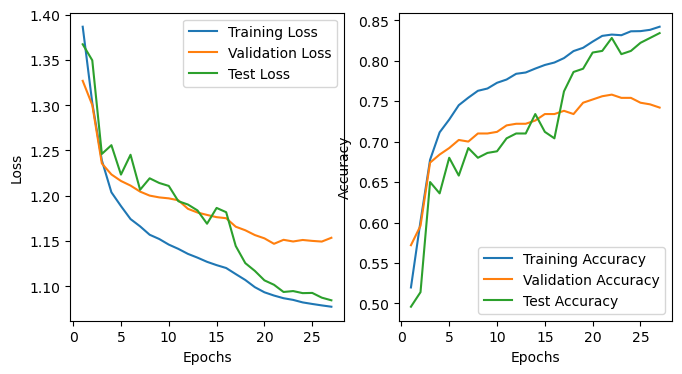

In [35]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.plot(list(range(1, len(training_losses) + 1)), training_losses, label='Training Loss')
plt.plot(list(range(1, len(val_losses) + 1)), val_losses, label='Validation Loss')
plt.plot(list(range(1, len(test_losses) + 1)), test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(list(range(1, len(training_accuracies) + 1)), training_accuracies, label='Training Accuracy')
plt.plot(list(range(1, len(val_accuracies) + 1)), val_accuracies, label='Validation Accuracy')
plt.plot(list(range(1, len(test_accuracies) + 1)), test_accuracies, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()